## Example: Vetical mast (wind shear)

In [9]:
import numpy as np 
import os
import matplotlib.pyplot as plt
from yawisi.parameters import SimulationParameters
from yawisi.wind_field import WindField
from yawisi.display import display_points
from yawisi.spectrum import Spectrum
from yawisi.locations import Locations, Grid
# from yawisi.kernels import CoherenceKernel
from yawisi.wind import Wind
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D

### Reading parameters

In [2]:
filename =  "config_vert_mast.ini"
params = SimulationParameters(filename)
print(params)

Number of Samples Initialized @ 3000
Sample Time Initialized @ 0.25
Wind Mean Speed Initialized @ 20
turbulence length scale for longitudinal component @ 170.0
turbulence length scale for transversal component @ 100.0
turbulence length scale for vertical component @ 35.0
Std of wind fluctuation of the longitudinal component @ 2.6
std of wind fluctuation of the transversal component @  2.2
std of wind fluctuation of the vertical component @ 1.56
PL Exp Law initialized  @ 0.15
Reference Height @ 60.0
Ymin @ 0.0
Ymax @ 0.0
Zmin @ 10.0
Zmax @ 90.0



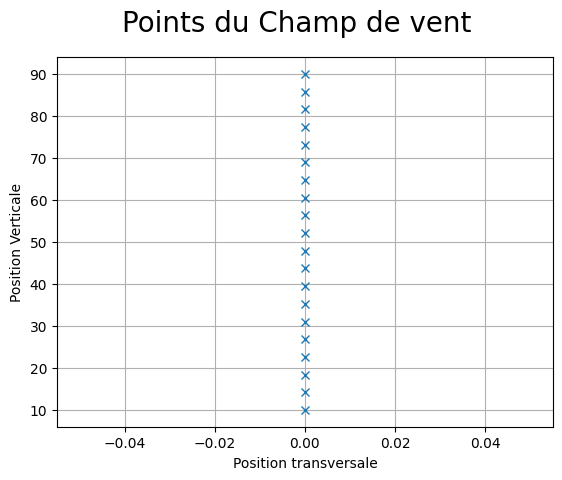

In [3]:
grid = Locations.create("grid", ny=(params.ny), nz=(params.nz), ymin=(params.ymin), ymax=(params.ymax), zmin=(params.zmin), zmax=(params.zmax))
display_points(grid)

### Generating wind field

In [4]:
wind_field = WindField(params)
wind_field.compute()

_______________Wind Field Display___________________________________
Simulation Parameters:
Samples Numbers: 3000
SampleTime: 0.25
WindField Points:
Point 0 : Y=0, Z=60
Wind Values have been initialized


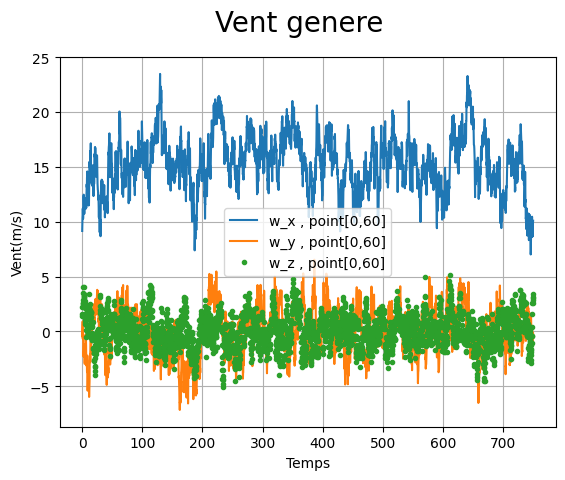

________________End OF DISPLAY____________________________________


In [8]:
from yawisi.display import  display_field
pts = [
            (0, 60)
        ]
wind_field.locations = Locations.create("points")
wind_field.locations.add_points(pts)
display_field(wind_field=wind_field)

In [10]:
wind_field.locations = Locations.create("grid", ny=(params.ny), nz=(params.nz), ymin=(params.ymin), ymax=(params.ymax), zmin=(params.zmin), zmax=(params.zmax))
ts = wind_field.get_uvwt()

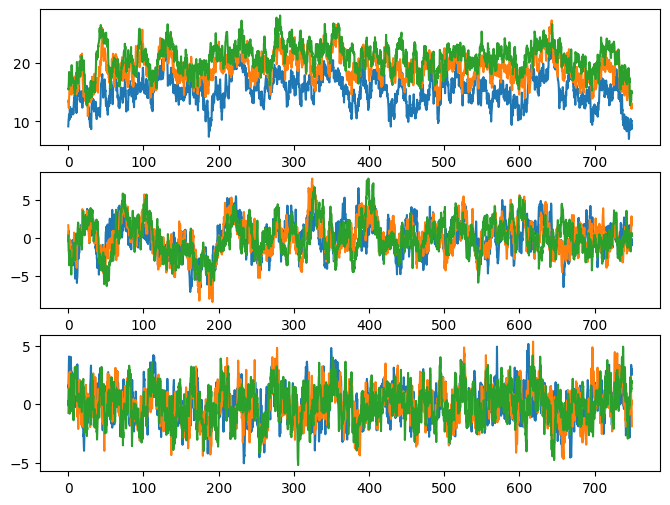

In [46]:
Time = []
ii = 0
while ii < wind_field.params.n_samples:
    Time.append(float(ii) * wind_field.params.sample_time)
    ii += 1
zarray = wind_field.locations.z_array()

fig = plt.figure(figsize=(8, 6))

# Create subplots for each wind component
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
i=0
while i < (len(zarray)): 
    ax1.plot(Time, ts[0, :, 0, i], label="u, point[%s,%s]" % (0, round(zarray[i])))
    ax2.plot(Time, ts[1, :, 0, i], label="v, point[%s,%s]" % (0, round(zarray[i])))
    ax3.plot(Time, ts[2, :, 0, i], label="w, point[%s,%s]" % (0, round(zarray[i])))
    i+= 8

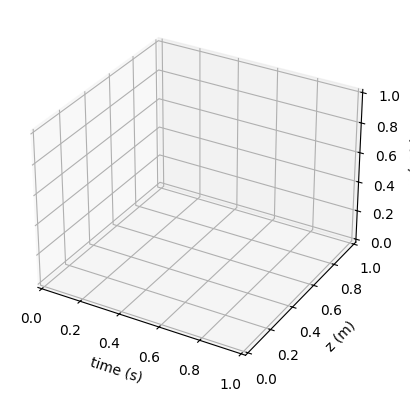

In [39]:
# zarray = wind_field.locations.z_array()
# x, z = np.meshgrid(Time[:600], zarray[::5])
# u = ts[0, :, 0, :]
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# # print(x.shape)
# # print(z.shape)
# # print(u[:, 0].reshape(-1, 1).shape)
# for i in range(u.shape[1], 5):
#     ax.plot3D(x.T, z.T, u[:600, i].reshape(-1, 1))

# # # for i, zi in enumerate(z):
# # #     if i % 5 == 0:
# # #         ax.plot3D(x.T, np.tile(zi, (600, 1)), u[:600, i // 5].reshape(-1, 1))
# ax.set_xlabel('time (s)')
# ax.set_ylabel('z (m)')
# ax.set_zlabel('u (m/s)')
# ax.grid(True)

In [52]:
params.wind_mean

20

### Vertical mean wind speed profile

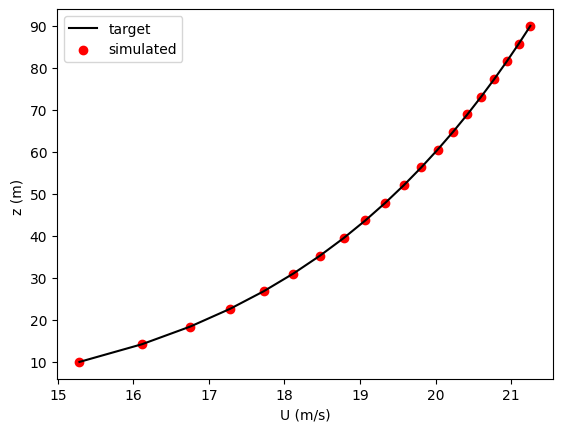

In [64]:
zr = 60
a = 0.15
U_target= params.wind_mean*(zarray/zr)**(a)
umean = np.mean(ts[0, :, 0, :], axis=0)
plt.figure()
plt.plot(U_target, zarray, color='k', label="target")
plt.scatter(umean, zarray, color='r', label = "simulated")
plt.ylabel('z (m) ')
plt.xlabel('U (m/s)')
plt.legend(loc="upper left")
plt.show()

In [54]:
U_target

array([20.        , 21.08247141, 21.9193243 , 22.60670275, 23.19276256,
       23.70526187, 24.16173829, 24.57401647, 24.95046646, 25.29724136,
       25.6190036 , 25.91937483, 26.20122711, 26.46687841, 26.71822789,
       26.95685208, 27.18407475, 27.40101877, 27.60864523, 27.80778341])

### Turbulence intensity

In [49]:
std_u = np.std(ts[0, :, 0, :], axis=0 )
std_v = np.std(ts[1, :, 0, :], axis=0 )
std_w = np.std(ts[2, :, 0, :], axis=0 )
print(std_u)

[2.53385836 2.52071598 2.5368331  2.49059677 2.49287636 2.41528572
 2.39040488 2.35460035 2.40878497 2.36517835 2.40186199 2.41358914
 2.37132215 2.42162963 2.40275352 2.41650798 2.39474211 2.43444182
 2.43055343 2.37385498]


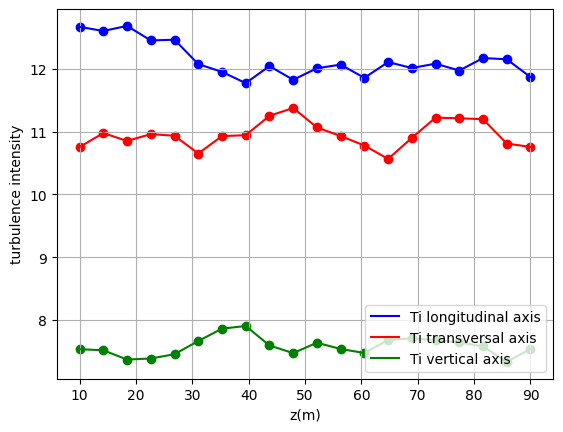

In [51]:
U_target = 20
Iu = std_u / U_target * 100
Iv =  std_v / U_target * 100
Iw = std_w / U_target * 100 
plt.figure()
plt.plot(zarray, Iu, color='b', label='Ti longitudinal axis')
plt.scatter(zarray, Iu, color='b')
plt.plot(zarray, Iv, color='r', label='Ti transversal axis')
plt.scatter(zarray, Iv, color='r')
plt.plot(zarray, Iw, color='g', label='Ti vertical axis')
plt.scatter(zarray, Iw, color='g')
plt.grid(True)
plt.xlabel("z(m)")
plt.ylabel("turbulence intensity")
plt.legend(loc="lower right")
plt.show()

### Co-coherence

In [65]:
from scipy.signal import detrend, csd

def coherence(X, Y, Fs=0.2, WINDOW='hann', NPERSEG=None, NOVERLAP=None, NFFT=None):
    # Get only the fluctuating part
    X = detrend(X, type='constant')
    Y = detrend(Y, type='constant')  # remove mean

    #Get cross spectrum 
    freq, pxy = csd(X, Y, fs=Fs, nperseg=NPERSEG, nfft=NFFT)

    # Get single point spectrum
    _, pxx = csd(X, X, fs=Fs, window=WINDOW, nperseg=NPERSEG,  nfft=NFFT)
    _, pyy = csd(Y, Y, fs=Fs, window=WINDOW, nperseg=NPERSEG,  nfft=NFFT)

    # Normalize the cross spectrum
    cocoh = np.real(pxy / np.sqrt(pxx * pyy))  # co-coherence
    Quad = np.imag(pxy / np.sqrt(pxx * pyy))  # quad-coherence

    return cocoh, Quad, freq

In [77]:
ts = wind_field.get_uvwt()
u = ts[0]
fs = 0.2
Time = []
ii = 0
while ii < wind_field.params.n_samples:
    Time.append(float(ii) * wind_field.params.sample_time)
    ii += 1
tmax = Time[-1]
f0 = 1/tmax
Nsamples, N = len(zarray), len(Time)
Nblock = 12
Ncoh = round(N/Nblock)

cocoh = np.zeros((Nsamples, Nsamples, Ncoh // 2))
for i in range(Nsamples):
    for j in range(Nsamples):
        coh, _, freq  = coherence(u[:, 0, i], u [:, 0, j], Fs=0.2, NPERSEG=Ncoh, NOVERLAP=int(round(Ncoh /2)), NFFT=Ncoh)
        cocoh[i, j, :] = coh[:Ncoh//2]

In [80]:
dz = grid.get_distance_matrix()
uniqueDist = np.unique(np.round(dz.flatten() * 100) / 100)
distTarget = [10,20,40,60]

In [82]:
## Averaging coherence 
cocoh = np.reshape(cocoh, (Nsamples*Nsamples, -1))
meanCoCoh = np.zeros((len(np.unique(uniqueDist)), cocoh.shape[1]))

for ii, dist in enumerate(np.unique(uniqueDist)):
    ind = np.where(np.round(dz.flatten() * 100) / 100 == dist)[0]
    meanCoCoh[ii, :] = np.nanmean(cocoh[ind, :], axis=0)

In [87]:
from yawisi.profile import Profile
profile = Profile(params)
umean = profile(grid)
mean_u_jk = 0.5 * np.add.outer(umean.ravel(), umean.ravel())
umean

array([15.28647351, 16.11383204, 16.75345852, 17.27883814, 17.72677753,
       18.11849288, 18.46738862, 18.78250259, 19.07023223, 19.3352805 ,
       19.581211  , 19.81079184, 20.02621821, 20.22926179, 20.42137415,
       20.60376026, 20.77743193, 20.94324738, 21.1019412 , 21.25414722])

(1000,)
(125,)


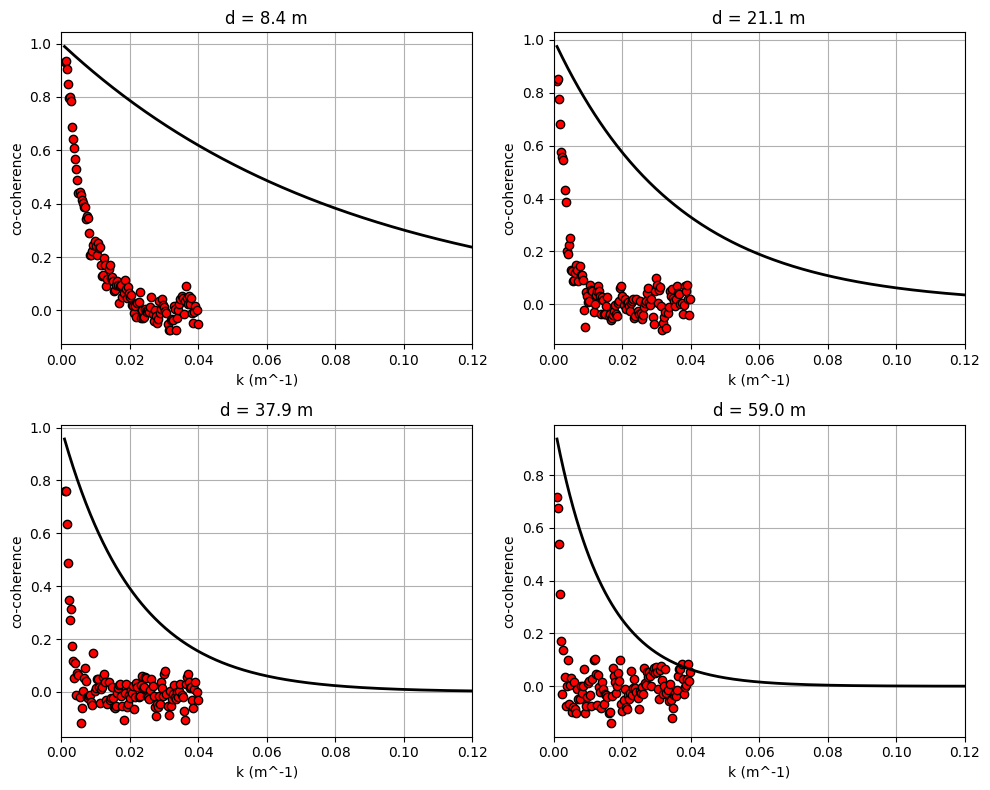

In [88]:
freq = np.linspace(0.003, 1, 1000)
k = 2 * np.pi * freq / 20

print(freq.shape)
print(meanCoCoh[0, :].reshape((meanCoCoh.shape[1],)).shape)


fig, axs = plt.subplots(2, 2, figsize=(10, 8))
for ii, target in enumerate(distTarget, 1):
    indDist = []
    ind = np.argmin(np.abs(uniqueDist - target))
    indDist.append(ind)
    ax = axs[(ii - 1) // 2, (ii - 1) % 2]
    ax.plot(k[:meanCoCoh.shape[1]], meanCoCoh[indDist, :].reshape((meanCoCoh.shape[1],)), 'ko', markerfacecolor='r')
    ax.plot(k, np.exp(-7.5 * dz[0, ind] * freq / umean[ind]), 'k', linewidth=2)
    ax.set_title('d = {:.1f} m'.format(uniqueDist[ind]))
    ax.set_xlim([0, 0.12])
    ax.set_xlabel('k (m^-1)')
    ax.set_ylabel('co-coherence')
    ax.grid(True)

plt.tight_layout()
plt.show()